In [ ]:
# Extra dependencies
%pip install -U pymystem3 gensim -qqq

# Service functions
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from pymystem3 import Mystem
from gensim.models import KeyedVectors
import gc
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

def memory_cleanup():
    "Clean up memory"
    gc.collect()
    torch.cuda.empty_cache()

def set_seed(seed: int) -> None:
    "Set seed for reproducibility"
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def display_metrics_with_ci(history: dict):
    """Plot mean and confidence intervals for train and test metrics"""
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import t

    seeds = list(history.keys())

    def mean_confidence_interval(data, confidence=0.95):
        n = len(data)
        m, se = np.mean(data), np.std(data) / np.sqrt(n)
        h = se * t.ppf((1 + confidence) / 2, n-1)
        return m, m-h, m+h

    r2_train_values = [history[seed]['train_r2'] for seed in seeds]
    r2_test_values = [history[seed]['test_r2'] for seed in seeds]
    r2_train_values = np.array(r2_train_values)
    r2_test_values = np.array(r2_test_values)

    r2_train_mean = np.mean(r2_train_values, axis=0)
    r2_test_mean = np.mean(r2_test_values, axis=0)

    r2_train_ci = np.array([mean_confidence_interval(r2_train_values[:, i]) for i in range(r2_train_values.shape[1])])
    r2_test_ci = np.array([mean_confidence_interval(r2_test_values[:, i]) for i in range(r2_test_values.shape[1])])

    plt.figure(figsize=(10, 6))
    plt.plot(r2_train_mean[1:], label='train')
    plt.fill_between(range(len(r2_train_mean[1:])), r2_train_ci[1:, 1], r2_train_ci[1:, 2], alpha=0.3)
    plt.plot(r2_test_mean[1:], label='test')
    plt.fill_between(range(len(r2_test_mean[1:])), r2_test_ci[1:, 1], r2_test_ci[1:, 2], alpha=0.3)
    plt.title('Mean R2 by epoch, with 95% CI')
    plt.xlabel('Epoch')
    plt.ylabel('R2')
    plt.legend()
    plt.show()

    # Calculate test metrics for best epoch
    mae_test_values = [history[seed]['test_mae'] for seed in seeds]
    rmse_test_values = [history[seed]['test_rmse'] for seed in seeds]
    mae_test_values = np.array(mae_test_values)
    rmse_test_values = np.array(rmse_test_values)

    best_epoch = np.argmax(r2_test_mean)
    best_epoch_r2 = r2_test_mean[best_epoch]
    best_epoch_mae = np.mean(mae_test_values, axis=0)[best_epoch]
    best_epoch_rmse = np.mean(rmse_test_values, axis=0)[best_epoch]

    r2_ci = mean_confidence_interval(r2_test_values[:, best_epoch])
    mae_ci = mean_confidence_interval(mae_test_values[:, best_epoch])
    rmse_ci = mean_confidence_interval(rmse_test_values[:, best_epoch])

    print(f'TEST METRICS FOR THE BEST EPOCH (#{best_epoch+1})')
    print(f'R2: mean = {best_epoch_r2:.4f}, 95% CI = [{r2_ci[1]:.4f}, {r2_ci[2]:.4f}]')
    print(f'MAE: mean = {best_epoch_mae:.4f}, 95% CI = [{mae_ci[1]:.4f}, {mae_ci[2]:.4f}]')
    print(f'RMSE: mean = {best_epoch_rmse:.4f}, 95% CI = [{rmse_ci[1]:.4f}, {rmse_ci[2]:.4f}]')

### Getting the data

In [ ]:

!mkdir data
!mkdir data/history
!wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1iqg1FIPfbrZWlung6gZqve1MeQWc0Je4&export=download&authuser=1&confirm=t' -O './data/dataset.csv'


--2024-12-26 11:06:34--  https://drive.usercontent.google.com/download?id=1iqg1FIPfbrZWlung6gZqve1MeQWc0Je4&export=download&authuser=1&confirm=t
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.194.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218678075 (209M) [application/octet-stream]
Saving to: ‘./data/dataset.csv’

./data/dataset.csv  100%[===================>] 208.55M  73.5MB/s    in 2.8s    

2024-12-26 11:06:39 (73.5 MB/s) - ‘./data/dataset.csv’ saved [218678075/218678075]



### Data load

In [ ]:
print("Loading and preprocessing data...")
df = pd.read_csv('./data/dataset.csv')

text_col_1 = 'description_no_numbers'
text_col_2 = 'title_company_location_skills_source'

Loading and preprocessing data...


In [ ]:
target_col = 'log_salary_from'

In [ ]:
title_company_location_skills_feature_template = """
Позиция: {position}
Компания: {company}
Место: {location}
Навыки: {skills}
Источник: {source}
"""

df['skills'] = df['skills'].fillna('Не указаны')
df[text_col_2] = df.apply(lambda x: title_company_location_skills_feature_template.format(
    position=x['title'],
    company=x['company'],
    location=x['location'],
    skills=x['skills'],
    source=x['source']
), axis=1)

In [ ]:
# Initialize tokenizer
m = Mystem()

def simple_tokenize(text):
    "Tokenize and lemmatize text"
    text = text.lower()
    lemmas = m.lemmatize(text)
    tokens = [re.sub(r'[\W_]+', '', lemma) for lemma in lemmas]
    tokens = [t for t in tokens if t.strip() != '']
    return tokens

# Build vocabulary and word2idx mapping
def build_vocab(texts, min_freq=2):
    "Build vocabulary with minimum frequency threshold"
    freq = {}
    for t in texts:
        for w in t:
            freq[w] = freq.get(w, 0) + 1

    freq = {k:v for k,v in freq.items() if v >= min_freq}
    word2idx = {'<PAD>':0, '<UNK>':1}
    for w in freq:
        if w not in word2idx:
            word2idx[w] = len(word2idx)
    return word2idx

# Preparing sequences
def text_to_seq(tokens, word2idx):
    "Convert tokens to sequence of indices"
    return [word2idx.get(w, 1) for w in tokens]

def pad_sequence(seq, max_len, pad_idx=0, left_pad=False):
    "Pad sequence to fixed length"
    seq_len = len(seq)
    if seq_len < max_len:
        pad_size = max_len - seq_len
        if left_pad:
            seq = [pad_idx]*pad_size + seq
        else:
            seq = seq + [pad_idx]*pad_size
    else:
        if left_pad:
            seq = seq[-max_len:]
        else:
            seq = seq[:max_len]
    return seq

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Model architecture

In [ ]:

class BiGRUCNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, gru_units=128, conv_filters=64,
                 kernel_size=3, row_max_length=1000):
        super(BiGRUCNNModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        if 'weights_matrix' in globals():
            self.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))

        self.gru = nn.GRU(embed_dim, gru_units, bidirectional=True, batch_first=True)
        self.conv = nn.Conv1d(in_channels=gru_units*2, out_channels=conv_filters,
                            kernel_size=kernel_size, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(conv_filters * (row_max_length//2), 1)

    def forward(self, x):
        emb = self.embedding(x)
        gru_out, _ = self.gru(emb)
        gru_out = gru_out.permute(0, 2, 1)
        conv_out = self.conv(gru_out)
        pooled = self.pool(conv_out)
        flat = pooled.flatten(start_dim=1)
        drop = self.dropout(flat)
        out = self.fc(drop)
        return out.squeeze(1)

### Training function

In [ ]:
def fit_eval(model, train_dl, test_dl, num_epochs=10, lr=1e-3, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.L1Loss()

    history = {
        "train_loss": [], "test_loss": [],
        "train_mae": [], "test_mae": [],
        "train_r2": [], "test_r2": [],
        "train_rmse": [], "test_rmse": []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        all_preds = []
        all_labels = []

        for Xb, yb in train_dl:
            Xb = Xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

        train_loss = np.mean(train_losses)
        train_mae = mean_absolute_error(all_labels, all_preds)
        train_r2 = r2_score(all_labels, all_preds)
        train_rmse = np.sqrt(mean_squared_error(all_labels, all_preds))

        # Evaluation phase
        model.eval()
        test_losses = []
        all_preds_test = []
        all_labels_test = []

        with torch.no_grad():
            for Xb, yb in test_dl:
                Xb = Xb.to(device)
                yb = yb.to(device)

                preds = model(Xb)
                loss = criterion(preds, yb)

                test_losses.append(loss.item())
                all_preds_test.extend(preds.cpu().numpy())
                all_labels_test.extend(yb.cpu().numpy())

        test_loss = np.mean(test_losses)
        test_mae = mean_absolute_error(all_labels_test, all_preds_test)
        test_r2 = r2_score(all_labels_test, all_preds_test)
        test_rmse = np.sqrt(mean_squared_error(all_labels_test, all_preds_test))

        # Update history
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_mae"].append(train_mae)
        history["test_mae"].append(test_mae)
        history["train_r2"].append(train_r2)
        history["test_r2"].append(test_r2)
        history["train_rmse"].append(train_rmse)
        history["test_rmse"].append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
              f"Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}, "
              f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

    return history

### Main experiment

Starting main experiment...

Starting for seed 42...
----------------------------------------------------------------------------------------------------
Loading pretrained word vectors...
--2024-12-26 11:10:07--  http://vectors.nlpl.eu/repository/20/180.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.200, 2001:700:112::200
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.200|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484452317 (462M) [application/zip]
Saving to: ‘rus_model.zip’

rus_model.zip       100%[===================>] 462.01M  15.3MB/s    in 32s     

2024-12-26 11:10:40 (14.4 MB/s) - ‘rus_model.zip’ saved [484452317/484452317]

Archive:  rus_model.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  
Epoch 1/20 | Train Loss: 0.5225, Test Loss: 0.3607, Train R2: -1.1456, Test R2: 0.4579, Train MAE: 0.5227, Test MAE: 0.3607

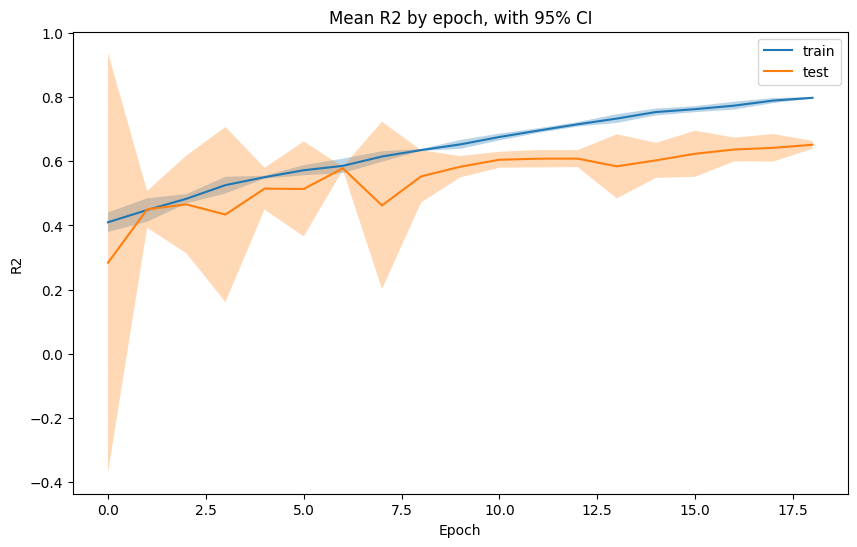

TEST METRICS FOR THE BEST EPOCH (#20)
R2: mean = 0.6517, 95% CI = [0.6393, 0.6640]
MAE: mean = 0.2875, 95% CI = [0.2804, 0.2946]
RMSE: mean = 0.3710, 95% CI = [0.3648, 0.3772]

Saving history...

Experiment completed successfully!


In [ ]:
print("Starting main experiment...")
experiment_name = 'bi_gru_cnn'
seeds = [42, 78687, 123123]
combined_history = {}

# Configuration
config = {
    "embed_dim": 256,
    "gru_units": 128,
    "conv_filters": 64,
    "kernel_size": 3,
    "batch_size": 32,
    "num_epochs": 20,
    "learning_rate": 1e-3
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for seed in seeds:
    print(f'\nStarting for seed {seed}...')
    print('-' * 100)

    set_seed(seed)
    combined_history[seed] = {}

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        df[[text_col_1, text_col_2]], df[target_col],
        test_size=0.2, random_state=seed
    )

    # Tokenize
    X_train_tokens = [simple_tokenize(txt1 + ' ' + txt2) for txt1, txt2 in zip(X_train[text_col_1], X_train[text_col_2])]
    X_test_tokens = [simple_tokenize(txt1 + ' ' + txt2) for txt1, txt2 in zip(X_test[text_col_1], X_test[text_col_2])]

    # Build vocabulary
    word2idx = build_vocab(X_train_tokens, min_freq=2)
    vocab_size = len(word2idx)

    # Get sequences
    row_max_length = max(max(len(t) for t in X_train_tokens),
                        max(len(t) for t in X_test_tokens))

    X_train_seq = [pad_sequence(text_to_seq(t, word2idx), row_max_length)
                   for t in X_train_tokens]
    X_test_seq = [pad_sequence(text_to_seq(t, word2idx), row_max_length)
                  for t in X_test_tokens]

    X_train_seq = np.array(X_train_seq)
    X_test_seq = np.array(X_test_seq)

    y_train = y_train.to_numpy(dtype=np.float32)
    y_test = y_test.to_numpy(dtype=np.float32)

    # Load pretrained word vectors
    print("Loading pretrained word vectors...")
    if 'w2v_model' not in globals():
        # Download the model if not already downloaded
        !wget http://vectors.nlpl.eu/repository/20/180.zip -O rus_model.zip
        !unzip rus_model.zip
        from gensim.models import KeyedVectors
        w2v_model = KeyedVectors.load_word2vec_format("/content/model.bin", binary=True)

    # Initialize embedding weights
    weights_matrix = np.zeros((vocab_size, config["embed_dim"]), dtype=np.float32)
    for word, idx in word2idx.items():
        if word in w2v_model:
            weights_matrix[idx] = w2v_model[word]
        else:
            weights_matrix[idx] = np.random.normal(scale=0.6, size=(config["embed_dim"],))

    # Create datasets
    train_dataset = TextDataset(X_train_seq, y_train)
    test_dataset = TextDataset(X_test_seq, y_test)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    # Initialize model
    model = BiGRUCNNModel(
        vocab_size=vocab_size,
        embed_dim=config["embed_dim"],
        gru_units=config["gru_units"],
        conv_filters=config["conv_filters"],
        kernel_size=config["kernel_size"],
        row_max_length=row_max_length
    )

    # Train and evaluate
    history = fit_eval(
        model=model,
        train_dl=train_dataloader,
        test_dl=test_dataloader,
        num_epochs=config["num_epochs"],
        lr=config["learning_rate"],
        device=device
    )

    memory_cleanup()
    combined_history[seed] = history

# Display metrics
print("\nDisplaying metrics across all seeds...")
display_metrics_with_ci(combined_history)

# Save history
print("\nSaving history...")
with open(f'./data/history/bi_gru_cnn_history.pickle', 'wb') as f:
    pickle.dump(combined_history, f, protocol=pickle.HIGHEST_PROTOCOL)

print("\nExperiment completed successfully!")

In [ ]:
1+1

2